 I need a function which takes some state and punches it through an affine (linear) transform. It should have the capability to do the mean and covariance.

 I suppose there's three scenarios:
 - Mean only (magnitude state)
 - Mean and covariance (Gaussian state)
 - Mean only but we're handed many samples (particle state)

We should also support moment and square root versions of these transforms.

The particle method is the easier to think about, simulate and implement although it's the most computationally intense. I can write experiments then go to unscented, then affine.

This means I can test them against each other.


calc Mean: [68.]
calc var: [38.16]
Mean: 67.891
Var: 39.566


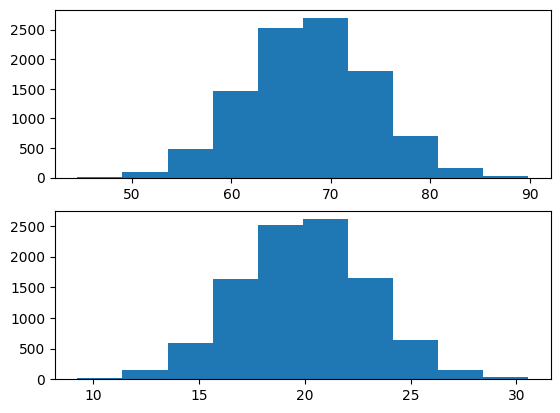

In [315]:
import numpy as np
from matplotlib import pyplot as plt

# Scenario is I have a temperature in degrees centigrade as a state but I have a y that comes in F

n = 10_000
R = 3

mux = 20
Sx = 3
temps_c = np.random.normal(mux,Sx, (n, 1))

def c2d(temps_c):
    return temps_c*(9/5) + 32


temps_f = c2d(temps_c) + np.random.normal(0,R, (n, 1))

# y = Hx
H = np.array([[9/5]])
mu_x = np.array([mux])
B = np.array([32])
Px = np.array([Sx**2])

def affine_mean_calc(H, mu_x, B):
    return H @ mu_x + B

def affine_cov_calc(R, H, Px):
    return H@Px@H.T + np.array([R**2])

def affine_transform(R, H, mu_x, B, Px):
    y = affine_mean_calc(H, mu_x, B)
    Py = affine_cov_calc(R, H, Px)
    return y,Py

y, Py = affine_transform(R, H, mu_x, B, Px)

print(f"calc Mean: {y}")
print(f"calc var: {Py}")
print(f"Mean: {np.mean(temps_f):.3f}")
print(f"Var: {np.var(temps_f):.3f}")

plt.subplot(2,1,1)
plt.hist(temps_f.flatten())
plt.subplot(2,1,2)
plt.hist(temps_c.flatten())
plt.show()

# Measurement model example

Say we have some measurement model $y = H x$, where $H := \begin{bmatrix}2 & 3\end{bmatrix}$. At some point in time we call the measurement function when our predicted state is $x := \begin{bmatrix}1\\2\end{bmatrix}$

The mean will be:
$$
\begin{align*}
y = H x \\
\implies y = \begin{bmatrix}2 & 3\end{bmatrix} x \\
\implies y = \begin{bmatrix}2 & 3\end{bmatrix} \begin{bmatrix}1\\2\end{bmatrix} \\
\implies y = (2 * 1) + (3 * 2) \\
\implies y = (2) + (6) \\
\implies y = 8 \\
\end{align*}
$$

If we have a covariance say, $P_x := \begin{bmatrix}1 & 0\\0 & 4\end{bmatrix}$ it's transform is this:
$$
\begin{align*}
P_y = H P_x H^T + R \\
\implies P_y = \begin{bmatrix}2&3\end{bmatrix} P_x \left(\begin{bmatrix}2&3\end{bmatrix}\right)^T + R \\
\implies P_y = \begin{bmatrix}2&3\end{bmatrix} P_x \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \begin{bmatrix}2&3\end{bmatrix} \begin{bmatrix}1 & 0\\0 & 4\end{bmatrix} \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \left(\begin{bmatrix}2&3\end{bmatrix} \begin{bmatrix}1 & 0\\0 & 4\end{bmatrix}\right) \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \left(\begin{bmatrix}2&3\end{bmatrix} \begin{bmatrix}1 & 0\\0 & 4\end{bmatrix}\right) \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \left(\begin{bmatrix}(2*1+3*0)&(2*0+3*4)\end{bmatrix}\right) \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \begin{bmatrix}2&12\end{bmatrix} \begin{bmatrix}2\\3\end{bmatrix} + R \\
\implies P_y = \begin{bmatrix}(2*2)+(12*3)\end{bmatrix} + R \\
\implies P_y = \begin{bmatrix}(4)+(36)\end{bmatrix} + R \\
\implies P_y = \begin{bmatrix}40\end{bmatrix} + R \\
\end{align*}
$$

In [316]:
import numpy as np
from src.dynamics_library.gaussian import Gaussian


mu_x = np.array([[1.0], [2.0], [0.0]])          # Initial guess
P = np.diag([1.0, 1.0, 0.2])                   # Uncertainty
prior = Gaussian.from_moment(mu_x, P)


In [317]:
from src.dynamics_library.gaussian_measurement_function import MeasurementFunctionProtocol
from src.dynamics_library.gaussian_return import GaussianReturn
import numpy as np

class DummyTransform(MeasurementFunctionProtocol):
    def __init__(self):
        super().__init__()
        self.beacon_1 = np.array([[2.0], [0.0], [1.0]])  # (3,1)

    def __call__(self, x: np.ndarray, return_grad: bool = False, return_hess: bool = False) -> GaussianReturn:
        d = self.beacon_1 - x  # (3,1)
        norm_d = np.linalg.norm(d)  # scalar

        y = np.array([[norm_d]])  # (1,1) output measurement

        grad = None
        hess = None

        if return_grad:
            grad = (-d / norm_d).T  # (1,3) Jacobian (row vector)
        
        if return_hess:
            # TODO: second derivative (Hessian) if you want (optional for now)
            pass

        return GaussianReturn(
            magnitude=y,
            grad_magnitude=grad,
            hess_magnitude=hess
        )

rv = DummyTransform()(x=mu_x,return_grad=True)
rv

GaussianReturn(magnitude=array([[2.44948974]]), gaussian_magnitude=None, grad_magnitude=array([[-0.40824829,  0.81649658, -0.40824829]]), hess_magnitude=None)

In [318]:

p = DummyTransform()
h = p.__call__
noise = None

mu = prior.mu
S = prior.sqrt_cov

result: GaussianReturn = h(x=mu, return_grad=True)

if not result.has_grad:
    raise ValueError("Affine transform requires gradient information (Jacobian) when no Gaussian is provided")

y_part = result.magnitude
J = result.grad_magnitude

if y_part.ndim == 1:
    y_part = y_part[:, None]

# Propagate uncertainty
SJ_T = J @ S.T
parts = [SJ_T]

if noise is not None:
    parts.append(noise.sqrt_cov)

# Stack all uncertainty contributions vertically
max_cols = max(p.shape[1] for p in parts)
padded_parts = [
    np.pad(p, ((0, 0), (0, max_cols - p.shape[1]))) if p.shape[1] < max_cols else p
    for p in parts
]
stacked = np.vstack(padded_parts)

# QR decomposition to obtain square-root of covariance
_, R = np.linalg.qr(stacked, mode="reduced")
SR = R.T

# Ensure full (n, n) shape
expected_dim = J.shape[0]
curr_rows, curr_cols = SR.shape
if curr_rows < expected_dim:
    pad_rows = expected_dim - curr_rows
    SR = np.pad(SR, ((0, pad_rows), (0, 0)))
if curr_cols < expected_dim:
    pad_cols = expected_dim - curr_cols
    SR = np.pad(SR, ((0, 0), (0, pad_cols)))

rF = Gaussian(y_part, SR)

In [319]:
y_part

array([[2.44948974]])

In [320]:
rF.mu

array([[2.44948974]])

We have a measurement that is as expected. Now we're going to get a gaussian that's [h(x); x] to prep for the conditional

In [321]:
return_hessian = False
return_gradient = False
system = None

def predict_density(x, system, return_gradient=False, return_hessian=False) -> GaussianReturn:
    return DummyTransform()(x=x,return_grad=return_gradient)

x = prior.mu

if return_hessian:
    py, dhdx, d2hdx2 = predict_density(x, system, return_gradient=True, return_hessian=True)

elif return_gradient:
    py, dhdx = predict_density(x, system, return_gradient=True)
    d2hdx2 = np.zeros((py.mu.shape[0], x.shape[0], x.shape[0]))
else:
    rv = predict_density(x, system)
    py = rv.gaussian_magnitude
    dhdx = np.zeros((py.mu.shape[0], x.shape[0]))
    d2hdx2 = np.zeros((py.mu.shape[0], x.shape[0], x.shape[0]))

ny = py.mu.shape[0]
nx = x.shape[0]

# Construct full S_aug: (ny+nx, ny+nx)
S_aug = np.zeros((ny + nx, ny + nx))
S_aug[:ny, :ny] = py.sqrt_cov  # top-left block is R
S_aug[ny:, ny:] = system.density.sqrt_cov  # bottom-right = state uncertainty


mu_aug = np.vstack([py.mu, x])
J_aug = np.vstack([dhdx, np.eye(nx)])

py_aug = Gaussian(mu_aug, S_aug)

return py_aug, J_aug

AttributeError: 'NoneType' object has no attribute 'mu'

In [ ]:
# P_y = H P_x H^T + R
# = [1 3] [1 0; 0 4] [1;3] + 0.5
# = (1*1*1 + 1*0*3 + 3*0*1 + 3*4*3) + 0.5
# = (1 + 0 + 0 + 36) + 0.5 = 37 + 0.5 = 37.5
    